<a href="https://colab.research.google.com/github/01-Projects-In-Python/Project-PhysiologicalSignals-MixedLinearModel/blob/main/Code-StressMonitoringUsingWearableSensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT: MIXED LINEAR MODEL REGRESSION

- Alexandra Garcia
- Yamileth Hercules

__a. Purpose:__<br>
Explore the physiological signals dataset and replicating the work Iqbal et al (2022) but using only one data analysis matrix, which is the linear mixed model

__b. Objectives:__<br>
    
1. Conduct an EDA analysis on the given dataset and identify missing values outliers.<br>
2. Identify what linear mixed model that the study used.<br>
3. Conduct the prediction tasks and interpret the predicted models. <br>
6. Compare the results with the study’s results.<br>
7. Conclusions.<br>

__b. Data:__<br>

The data is the one that is provide in GitHub about the stress experiment. We can see as follow the description of the variables:


| Variable | Description|
| --- | --- |
| Participant | Number of Particpant in the experiment|
| HR| Heart for every second during the test|  
| RR| respiratory Rate for every second during the test |
| Time| Time in timestamp UNITs|
| Label| Binary variable 0= normal, 1= stress situations|

[Stress Monitoring Using Wearable Sensors Study Link Here](https://www.mdpi.com/1424-8220/22/21/8135)

## Objective 1: Conduct an EDA analysis on the given dataset.

In [ ]:
!pip install -q statsmodels


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('Improved_All_Combined_hr_rsp_binary.csv')
df.head()

,Participant,HR,respr,Time(sec),Label
0,2,118.00,12.127693,1644227583,0
1,2,113.50,12.127693,1644227584,0
2,2,93.00,12.127693,1644227585,0
3,2,93.25,12.127693,1644227586,0
4,2,86.40,12.127693,1644227587,0


In order to simplify the analysis of the data, we will modify the columns' names:

In [ ]:
df.rename(columns={'Time(sec)': 'Time', 'Label': 'Group'}, inplace=True)

In [ ]:
# Verifying the data shape
df.shape

(112516, 5)

##### **- Missing values:**

In [ ]:
# Checking missing values
df.isnull().sum()

Participant     0
HR             44
respr           0
Time            0
Group           0
dtype: int64

As we can see, the 'HR' variable contains 44 null values, therefore, we will drop them based on they represent less than 5% of the data and we want to use the same observations that are used in the study:

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Checking null values
df.isnull().sum()

Participant    0
HR             0
respr          0
Time           0
Group          0
dtype: int64

In [ ]:
# Verifying the type of variables that we have in the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112472 entries, 0 to 112515
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Participant  112472 non-null  int64  
 1   HR           112472 non-null  float64
 2   respr        112472 non-null  float64
 3   Time         112472 non-null  int64  
 4   Group        112472 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 5.1 MB


We can see that the values for the 'Time' variables do not make sense so we will transform the `Time` and get the exact time in Hours.

In [ ]:
df['Time'] = df.groupby('Participant')['Time'].transform(lambda x: (x - x.min())/3600)

With the above transformation we allowed that `Time` is and hours as mentioned in the article.

##### **- Data distribution:**

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Participant,112472.0,18.475923,9.871188,2.000000,10.000000,18.000000,27.000000,35.000000
HR,112472.0,80.216177,12.732206,49.000000,71.330000,77.890000,87.020000,146.780000
respr,112472.0,12.465400,2.030968,5.204728,11.191836,12.743508,13.877583,18.163532
Time,112472.0,0.460113,0.266660,0.000000,0.229653,0.459306,0.688958,0.990278
Group,112472.0,0.327326,0.469239,0.000000,0.000000,0.000000,1.000000,1.000000


#### - Interpretation:
* As we can see the describe function takes `Group` as a continuous variable even though is a binary variable because we did not specify that is a categorical variable.
* The variable `Time` is a Unix timestamp that is measured in seconds and after we transform we got hours.
* The Standard deviation of HR is very high which represents that might be skewness in the data.


In [ ]:
df.groupby('Participant')['HR'].agg(['min', 'max', 'mean', 'median','std']).T

Participant,2,3,4,5,6,7,8,9,10,11,...,26,27,28,29,30,31,32,33,34,35
min,58.220000,59.150000,62.650000,58.480000,58.000000,59.570000,62.380000,59.780000,58.930000,52.000000,...,54.300000,60.050000,57.370000,55.000000,59.300000,58.230000,50.000000,66.000000,73.870000,59.220000
max,137.100000,87.840000,98.470000,96.630000,99.280000,85.000000,114.830000,120.100000,146.780000,112.580000,...,123.280000,93.200000,114.930000,141.080000,114.620000,97.720000,98.130000,96.500000,90.000000,116.230000
mean,78.447930,75.994157,77.218345,83.074177,72.512466,71.422783,96.295720,101.414849,88.396975,89.026259,...,79.549554,73.896705,81.029939,98.295227,85.964701,76.782881,62.262186,86.080654,82.543719,75.289838
median,75.300000,76.160000,76.450000,83.830000,72.120000,71.220000,99.320000,100.470000,85.360000,89.050000,...,77.700000,72.880000,82.350000,102.400000,84.420000,76.170000,60.580000,86.270000,82.150000,73.520000
std,13.413596,4.155899,7.575542,6.431390,5.014224,4.618734,10.224483,10.164660,16.326825,8.285467,...,10.712565,5.430952,12.332351,16.794091,9.419171,6.091875,8.280512,4.846012,3.806353,9.893479


In [ ]:
df.groupby('Participant')['respr'].agg(['min', 'max', 'mean','median','std']).T

Participant,2,3,4,5,6,7,8,9,10,11,...,26,27,28,29,30,31,32,33,34,35
min,8.480536,9.234443,11.595368,10.974532,11.852458,12.234731,7.451647,9.437131,9.387064,9.965969,...,10.480383,10.647792,7.517156,5.204728,8.554282,8.695998,12.337177,9.423638,11.233506,9.829590
max,15.127808,14.808436,15.772370,16.075846,15.762738,17.130514,16.994025,14.134816,14.010341,16.064586,...,14.023200,14.878682,12.726770,14.453659,13.629668,14.965090,17.897041,14.830143,14.400924,15.690750
mean,12.126521,13.208756,13.735281,12.993417,14.037550,13.925995,11.967771,12.132573,12.039461,12.728166,...,11.956576,13.024394,9.829157,9.628876,11.024555,12.677523,15.816242,11.920354,12.773763,12.850405
median,12.312079,13.275959,13.777481,12.930899,14.188784,13.930729,12.769672,12.132115,12.293548,12.764485,...,11.950287,13.024292,9.829884,9.623799,11.225580,13.147538,16.275578,11.863836,12.705280,12.575614
std,1.472326,1.029523,0.867415,1.045008,0.992193,0.973671,2.329243,1.214352,1.102151,1.148320,...,0.683244,0.912840,1.348632,1.827553,1.231461,1.514992,1.275558,1.274480,0.913043,1.399093


#### - Interpretation:

As we can observe in the tables above about statistics measure values  between the participant some of them are very differents. We can observe for example in `HR` there are some subjects that have a lot of variance with small min and high max values and other the variance are not quite large. We may see that fact reflect in the plots.  


In [ ]:
def graph_variables(column_name):
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=2)

    #create histograms
    plt.figure(figsize=(15,8))
    axs[0].hist(df[column_name], edgecolor='black')
    axs[1].boxplot(df[column_name])

    #add title to each histogram
    axs[0].set_title('Histogram ' + column_name)
    axs[1].set_title('Boxplot ' + column_name)


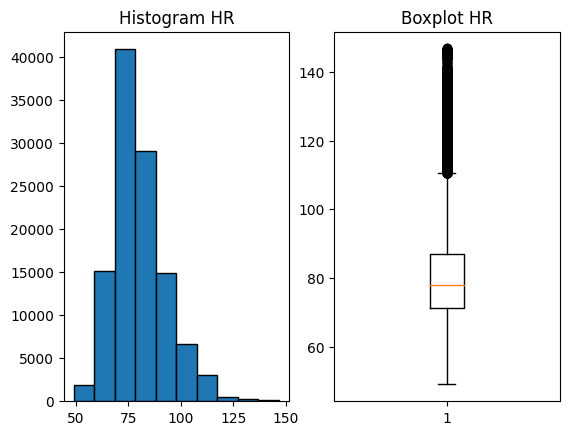

<Figure size 1500x800 with 0 Axes>

In [ ]:
graph_variables("HR")

#### - Intepretation:

Looking the univarite analysis for the response variable `HR`, we can easily observe that almost follow a normal distribution but a litle skewed to the right. Also, we can see that migh be outliers present in the variable.

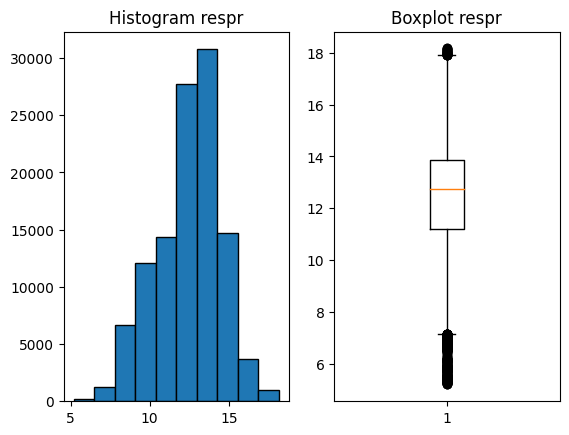

<Figure size 1500x800 with 0 Axes>

In [ ]:
graph_variables("respr")

#### - Intepretation:

Looking the univariete analysis for the response variable `respr`, we can easily observe that `respr` almost follow a bell shape distribution. Also, we can see that migh be outliers present in the variable.

##### **- Outliers Interpretation:**

We think that outliers should not be eliminated in this kind of experimental design measuring as predictor stress over time because it is crucial to carefully consider the nature of data, potential causes of outliers, and the impact on the analysis of these points. The principal reasons are:

* Preserving data integrity: Outliers may contain valuable information and reflect important characteristics of the data. Removing outliers can distort the underlying patterns and relationships in the data, leading to biased or inaccurate results.
* Reflecting real-world variability: Outliers can occur naturally due to various factors such as individual differences between the subjects or groups, measurement errors, or unexpected events. In a quasi-experimental design, it is important to capture the natural variability of stress levels and related physiological responses. Removing outliers may result in an overly idealized or unrealistic representation of the data.
* Robustness of statistical analysis: Many statistical techniques used for analyzing data, such as regression models, are designed to handle a certain degree of outliers. These methods are often robust and can provide reliable results even in the presence of outliers. Eliminating outliers may not be necessary if appropriate statistical techniques are employed.



Text(0, 0.5, 'HR')

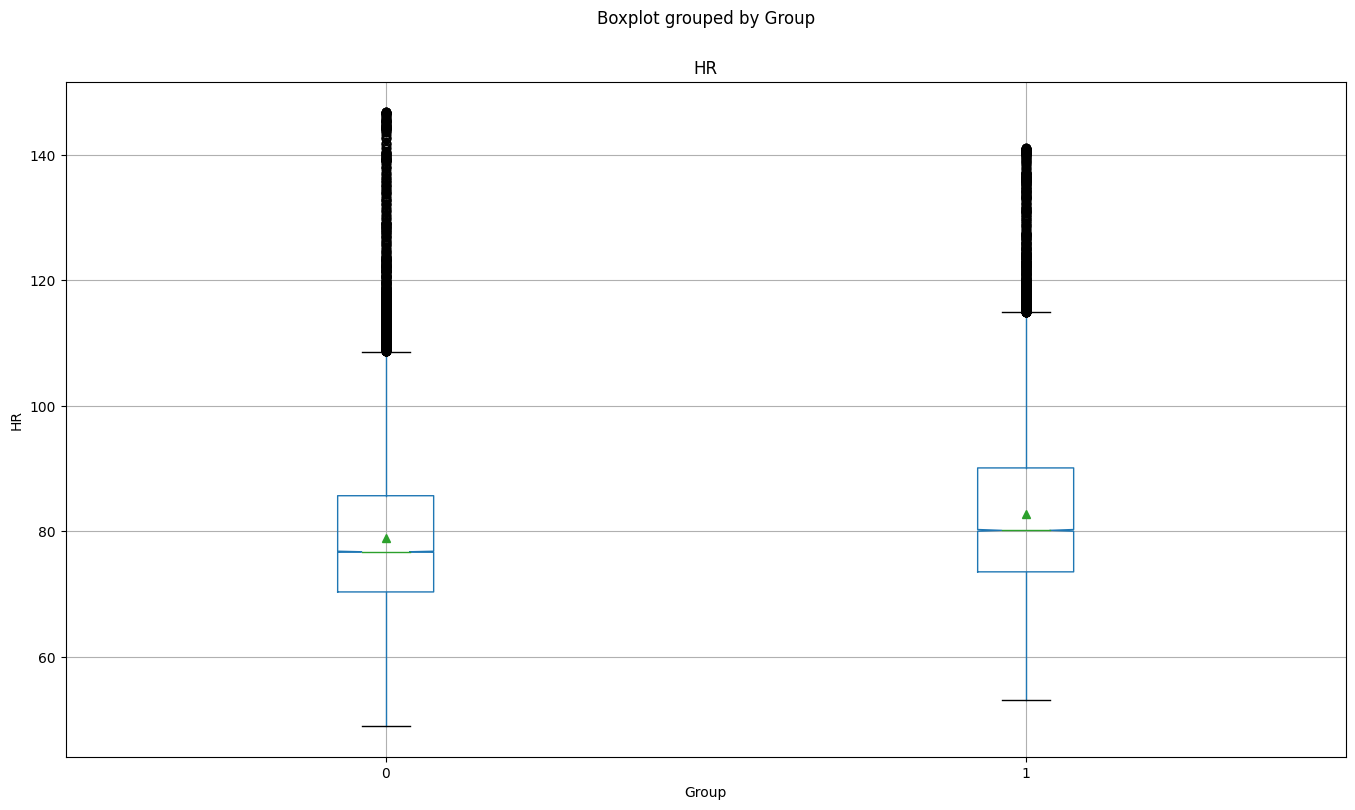

In [ ]:
boxplot = df.boxplot(["HR"], by = ["Group"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Group")
boxplot.set_ylabel("HR")


#### - Interpretation:

Looking at the boxplot, the distribution and variances of the `HR` look fairly similar between the Groups. The boxplot also indicates that there may outliers present in both groups.

Text(0, 0.5, 'Respiratory Rate ')

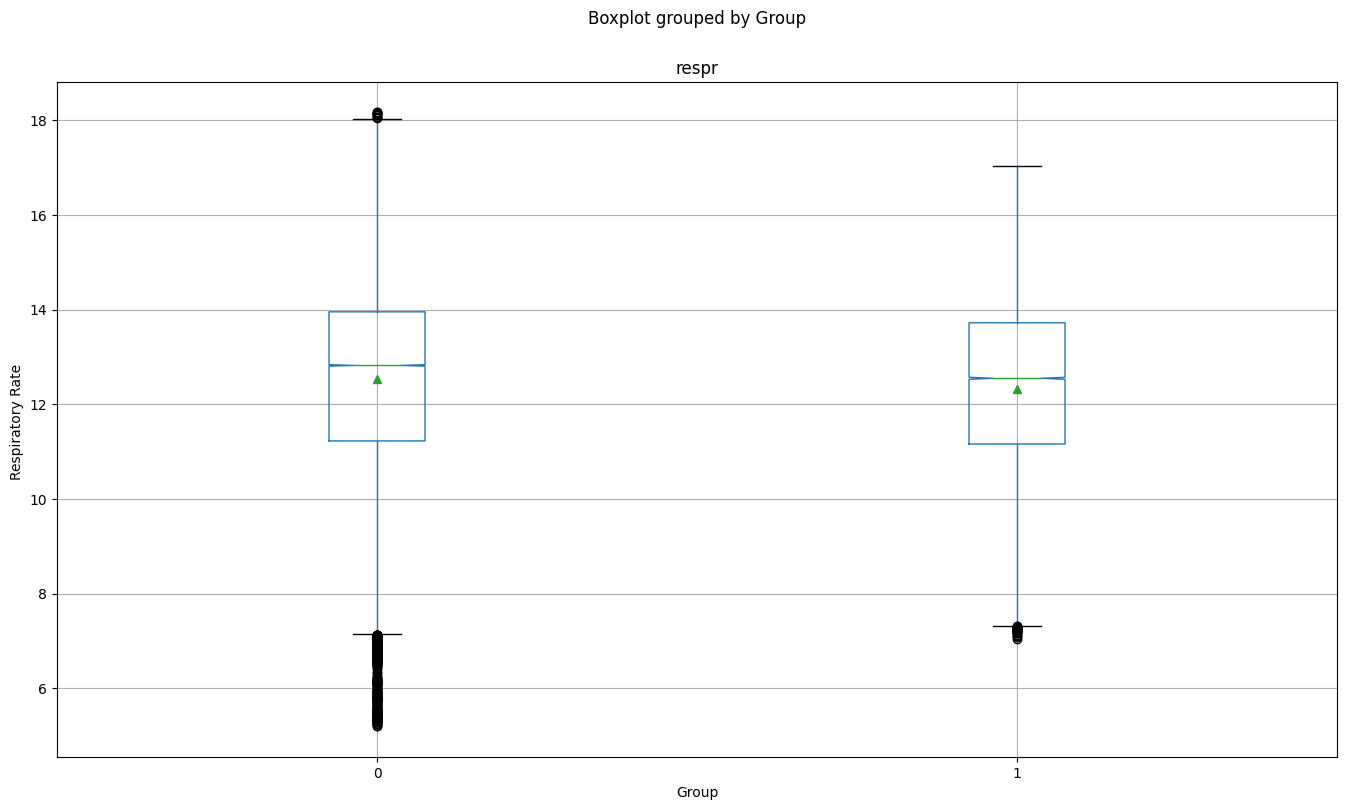

In [ ]:
boxplot = df.boxplot(["respr"], by = ["Group"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Group")
boxplot.set_ylabel("Respiratory Rate ")

#### - Interpretation:

Looking at the boxplot, the distribution and variances of the `RR` look fairly similar between the Groups. The boxplot also indicates that there may outliers present in both groups, but more in the Group 0(normal).

Text(0, 0.5, 'HR')

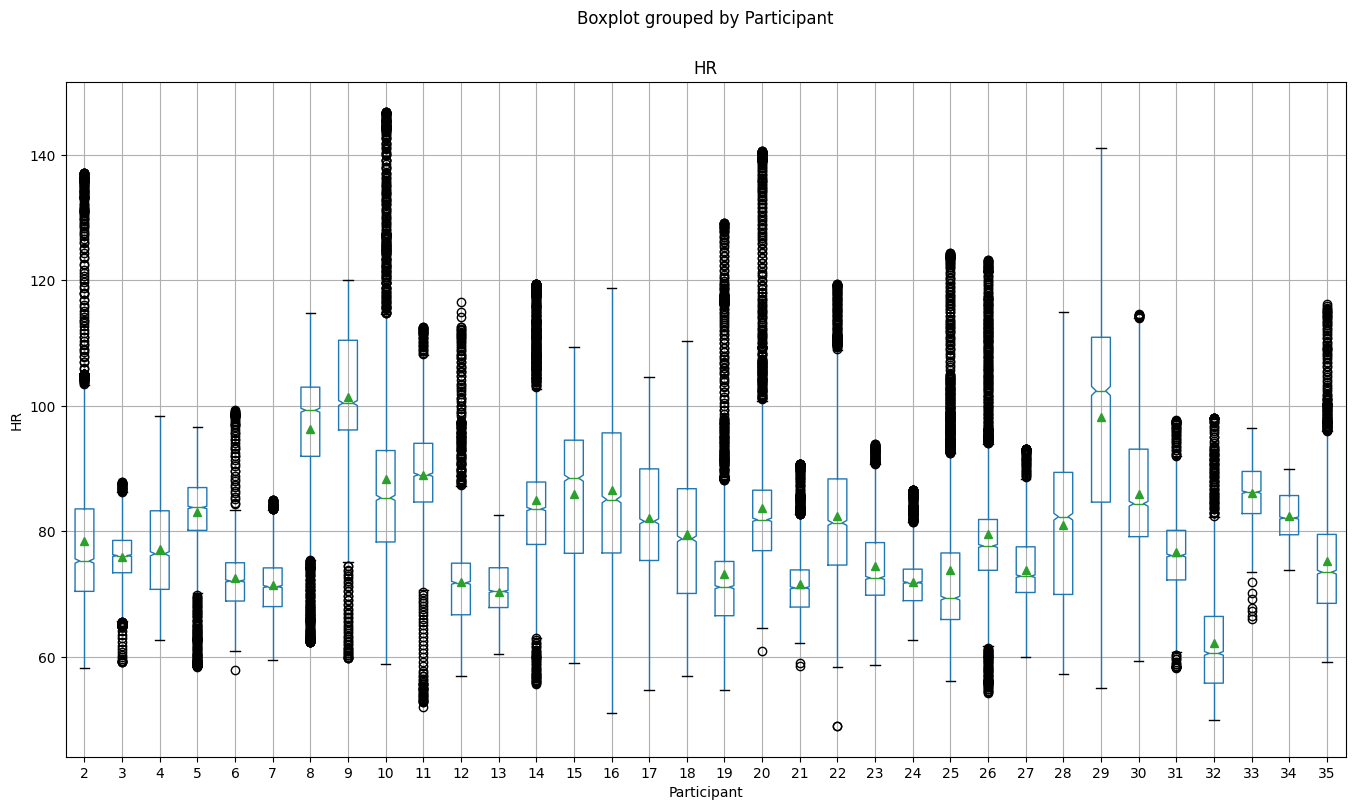

In [ ]:
boxplot = df.boxplot(["HR"], by = ["Participant"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Participant")
boxplot.set_ylabel("HR")


Text(0, 0.5, 'HR')

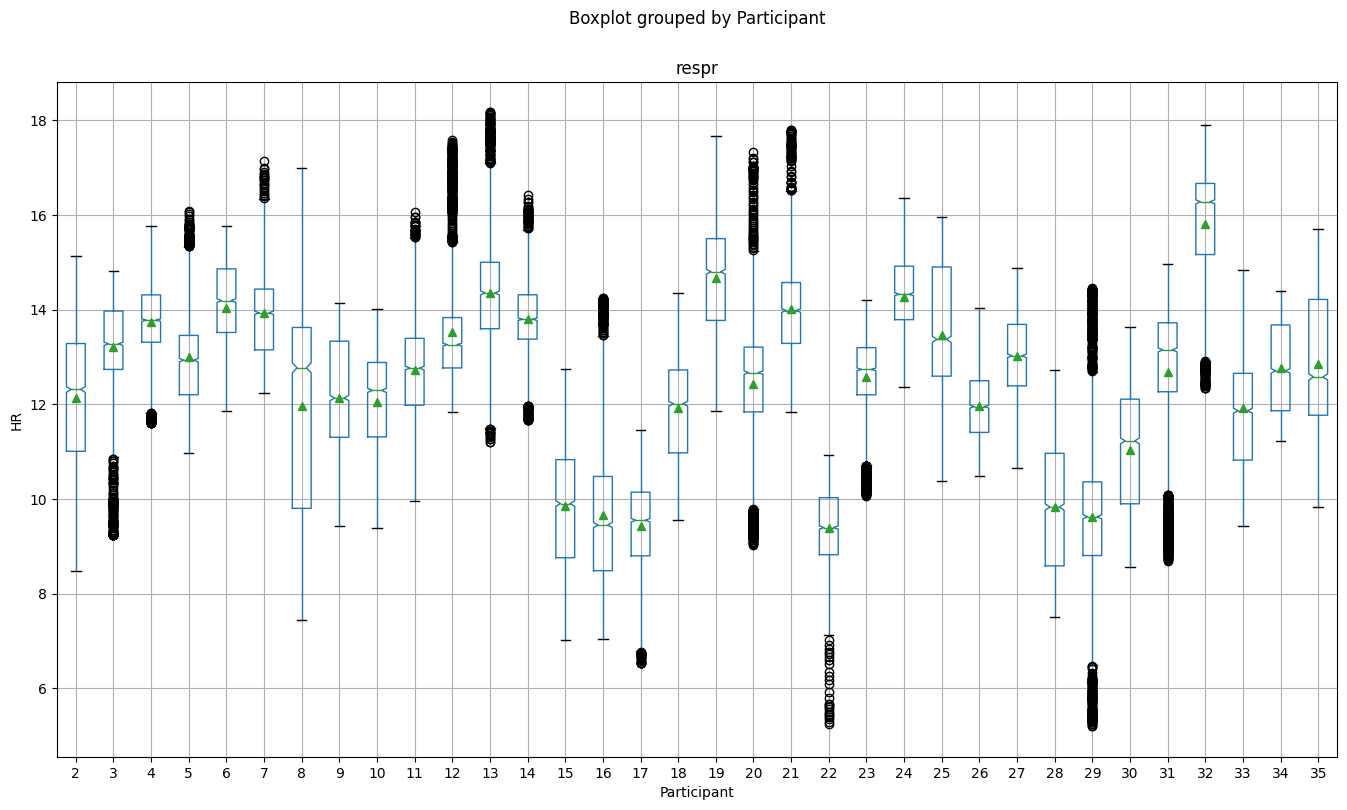

In [ ]:
boxplot = df.boxplot(["respr"], by = ["Participant"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Participant")
boxplot.set_ylabel("HR")

#### - Interpretation:

As we mentioned in the description analysis of statistics values above, the variance of `HR` and `respr` between each subject are very differents and also we can see some outliers in the data points. It is normal that the data could have that variance because is the human nature to have differents reactions and differents emotions during stress situations.

##### **- Correlation:**

To see correlation between the variables we are going to oibserve scatterplot and pearson correlation between the  variables.

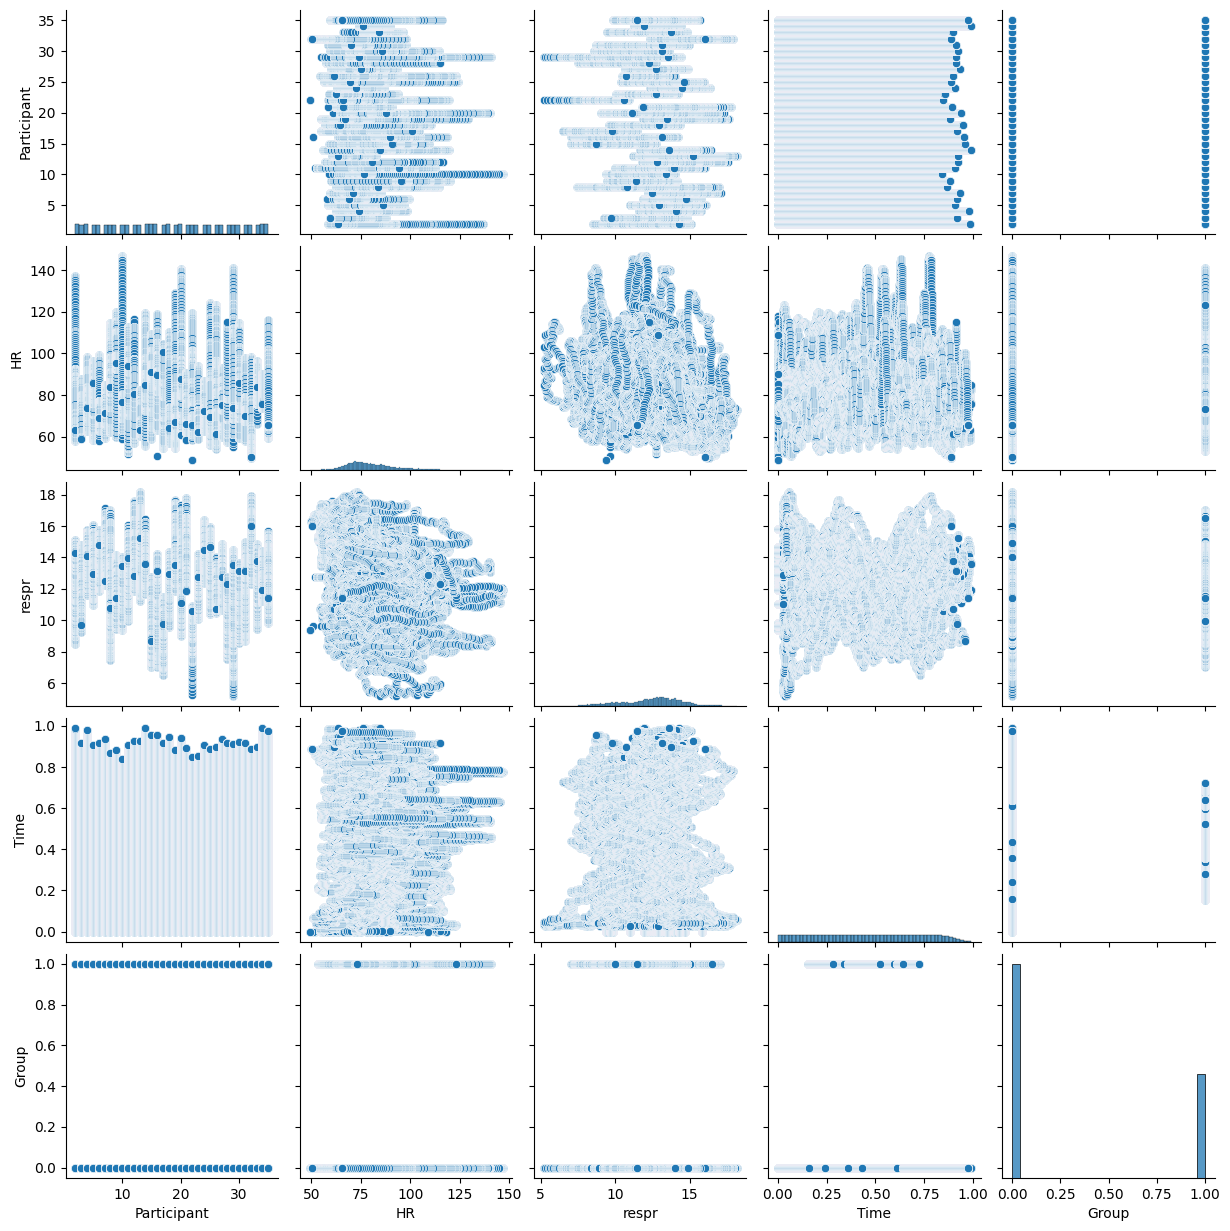

In [ ]:
sns.pairplot(df)

Since one of the assumptions of the Linear Mixed-Effect model is that the response and explanatory variables have a linear relationship, we will calculate their correlation through Pearson's indicator and plot heatmap:

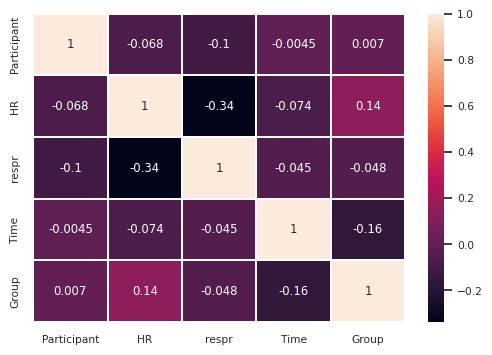

In [ ]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (6, 4))
sns.heatmap(df.corr(), annot = True, linewidths = 0.01, linecolor = 'white')
plt.show()

We interpret the results of the Pearson's correlation as follows:

Weak correlation: 0 < |r| < 0.3
Moderate correlation: 0.3 < |r| < 0.7
Strong correlation: |r| > 0.7

Therefore, the table and heatmap above show the Participant and Time variables have a strong positive correlation of 0.98, this result is pretty logic because the time depends on each participant.

In [ ]:
df_grouped = df.groupby('Participant').mean()

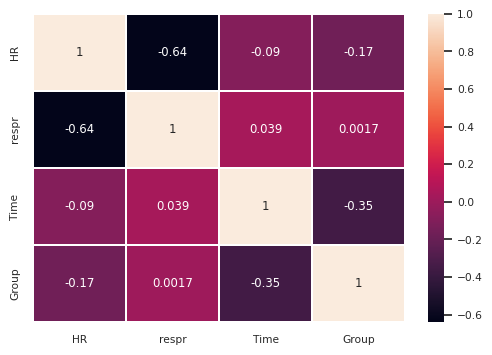

In [ ]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (6, 4))
sns.heatmap(df_grouped.corr(), annot = True, linewidths = 0.01, linecolor = 'white')
plt.show()

In the above heatmap we grouped the data by the 'Participant' variable in order to see the correlation of the variables based on each patient's result, we can see in the above heatmap that the 'resp' variable has a moderate positive correlation to the 'HR' variable (-0.64) which could mean deeper breath reduce heart rate.

## Objective 2: Identify what linear mixed model that the study used.

The Linear Mixed-Effect Model used in the analysis was implemented in order to understand the relationship, characteristics or trends within a population based on the sample.<br>

Important components of the study:<br>

- Purpose: The purpose of this study is to analyze how the stressors impact the HR and RR considering the changes in these variables tend to be related over time for each patient.

- Variables in the model:<br>

a. `Participant` variable: The study recognize each participant has a different initial point of HR and RR and during the effect of the predictors may differ on the HR and RR variable across individuals during the study because different subjects respond different in Heart Rates and Respiratory Rate to the stress.<br>
b. `Time`: We included the `Time` variable as a fixed and random effect because both the study wanted to analyze the average effect of time on the HR and RR variables across all participants (fixed effect) as well as the individual-specific variation in the relationship between time and the response variables (random effect).<br>
c. `Group`: This variable is included in the study as a fixed effect which means we want to analyze the average difference of the effect of the stressors, represented by the `Group` variable in the HR and RR variables.<br>
d. Interaction between `Time` and `Group`: This interaction is a fixed effect and the model wants to determine if there is a significant difference in the HR and RR over time between the stress and normal situations in the subjects.

## Objective 3: Conduct the prediction tasks and interpret the predicted models.


First we are going to create the divide the data and training and testing in order to make the prediction

In [ ]:
#Dividing the prediction and trainting and test dataset
from sklearn.model_selection import train_test_split
df_train,df_test= train_test_split(df, test_size = 0.20, random_state =1)
print(df_train.shape)
print(df_test.shape)

(89977, 5)
(22495, 5)


### `HR` Model

In [ ]:
# Run LMER
md = smf.mixedlm('HR ~ Time + C(Group) + Time:C(Group)', df_train, groups=df_train['Participant'], re_formula='~1+Time')
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  HR          
No. Observations:   89977    Method:              REML        
No. Groups:         34       Scale:               84.4273     
Min. group size:    2420     Log-Likelihood:      -327452.9539
Max. group size:    2886     Converged:           Yes         
Mean group size:    2646.4                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           80.115    1.794 44.655 0.000 76.599 83.631
C(Group)[T.1]        2.843    0.177 16.021 0.000  2.495  3.191
Time                -2.277    1.643 -1.386 0.166 -5.497  0.943
Time:C(Group)[T.1]   2.137    0.405  5.281 0.000  1.344  2.931
Group Var          109.264    2.902                           
Group x Time Cov   -63.106    2.226                           
Time 

In [ ]:
coefficients= mdf.params[:4]
coefficients

Intercept             80.114964
C(Group)[T.1]          2.843191
Time                  -2.277088
Time:C(Group)[T.1]     2.137329
dtype: float64

In [ ]:
random_effects = mdf.random_effects
random_effects

{2: Group   -0.638243
 Time    -2.238774
 dtype: float64,
 3: Group   -2.920963
 Time    -2.607873
 dtype: float64,
 4: Group     3.031703
 Time    -12.144644
 dtype: float64,
 5: Group    1.654076
 Time     2.517701
 dtype: float64,
 6: Group   -8.227286
 Time     0.845270
 dtype: float64,
 7: Group   -9.124786
 Time     0.976080
 dtype: float64,
 8: Group    20.687403
 Time    -10.872706
 dtype: float64,
 9: Group    29.210235
 Time    -18.103285
 dtype: float64,
 10: Group    -0.294310
 Time     19.972434
 dtype: float64,
 11: Group    5.375755
 Time     7.132060
 dtype: float64,
 12: Group   -8.314188
 Time     0.011966
 dtype: float64,
 13: Group   -8.694620
 Time    -2.602587
 dtype: float64,
 14: Group    3.204219
 Time     2.956434
 dtype: float64,
 15: Group    3.396924
 Time     4.389271
 dtype: float64,
 16: Group    11.606814
 Time    -10.762440
 dtype: float64,
 17: Group    4.526475
 Time    -5.765717
 dtype: float64,
 18: Group     4.643596
 Time    -11.077493
 dtype: fl

#### - Interpretation:
* Intercerpt: When the values of the predictors is cero, the average value of HR is 80.11
* Group[T.1]: The average difference in the HR variable is 2.84 between the Group 1 (Stress) and the Group 0 (Normal) while holding constants the other predictor variables.
* Time: When Time variable changing in 1 unit, the HR variable will dicrease in average, 2.27 units. However, the p-value for this variable is > 0.05, which means Time variable is not significant for the model.
* Time*Group[T.1]: When Time variable changing in 1 unit, for the Stress Group the HR variable will increase 2.13 units.

### `respr` Model

In [ ]:
# Run LMER
md = smf.mixedlm('respr ~ Time + C(Group) + Time:C(Group)', df_train, groups=df_train['Participant'], re_formula='~1+Time')
mdf1 = md.fit(method=["lbfgs"])
print(mdf1.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  respr       
No. Observations:   89977    Method:              REML        
No. Groups:         34       Scale:               1.2010      
Min. group size:    2420     Log-Likelihood:      -136174.6508
Max. group size:    2886     Converged:           Yes         
Mean group size:    2646.4                                    
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          12.678    0.355  35.694 0.000 11.982 13.374
C(Group)[T.1]       0.296    0.021  14.001 0.000  0.255  0.338
Time               -0.296    0.362  -0.820 0.412 -1.005  0.412
Time:C(Group)[T.1] -1.349    0.048 -27.950 0.000 -1.444 -1.255
Group Var           4.287    0.943                            
Group x Time Cov   -2.804    0.808                            
Time 

In [ ]:
coefficients1= mdf1.params[:4]
coefficients1

Intercept             12.677837
C(Group)[T.1]          0.296345
Time                  -0.296375
Time:C(Group)[T.1]    -1.349128
dtype: float64

In [ ]:
random_effects1 = mdf1.random_effects
random_effects1

{2: Group   -1.741956
 Time     2.857870
 dtype: float64,
 3: Group    0.771742
 Time    -0.130502
 dtype: float64,
 4: Group    1.376191
 Time    -0.217962
 dtype: float64,
 5: Group    0.379282
 Time     0.351499
 dtype: float64,
 6: Group    0.955992
 Time     1.358218
 dtype: float64,
 7: Group    2.437708
 Time    -2.084674
 dtype: float64,
 8: Group    2.543353
 Time    -6.976087
 dtype: float64,
 9: Group   -1.359263
 Time     2.290967
 dtype: float64,
 10: Group   -0.020000
 Time    -0.988411
 dtype: float64,
 11: Group   -0.156543
 Time     0.975438
 dtype: float64,
 12: Group    1.757405
 Time    -1.466383
 dtype: float64,
 13: Group    2.828706
 Time    -1.971223
 dtype: float64,
 14: Group    2.036489
 Time    -1.370752
 dtype: float64,
 15: Group   -2.690963
 Time     0.241987
 dtype: float64,
 16: Group   -3.203843
 Time     0.838015
 dtype: float64,
 17: Group   -2.212261
 Time    -1.780351
 dtype: float64,
 18: Group   -0.451271
 Time    -0.233299
 dtype: float64,
 19: 

#### - Interpretation:
* Intercerpt: When the values of the predictors is cero, the average value of RR is 12.67
* Group[T.1]: The average difference in the RR variable is 0.29 between the Group 1 (Stress) and the Group 0 (Normal) while holding constants the other predictor variables. We can see that this number represents that the difference for both groups is not meaningful.
* Time: When Time variable changing in 1 unit, the RR variable will dicrease in average, 0.29 units. However, as in the previous model, the p-value for this variable is > 0.05, which means Time variable is not significant for the model.
* Time*Group[T.1]: When Time variable changing in 1 unit, for the Stress Group the RR variable will decrease 1.34 units.

## Objective 4. Compare the results with the study’s results.

To compare the results of the study we are going to evaluate our assumptions that we made as we mentioned before, try to analyze the parts that the article mentions about the data and validate the results that we obtain.

##### **- Assumptions:**

* Missing values: We eliminate missing values as well as the article did because we can see that the number of observations or the sample size in the article is equal to 112,472 for both models.
* Sample Size: The paper does not mention the number of samples that were used to train the model, we split the data in 80:20. *0 for the training and 20% for the test.
* The random seed also can change a little bit the result but not should change the trend of the result if the data is balance.
* Outliers: The article does not mention anything about the outliers and we decided not to eliminate them because of the nature of the data.
* Ramdon effect: We decided to put `Time` as a random effect as mentioned in the article.
* Fixed Effect: The article mentions clearly that Group and the interaction term of Time and Group should be fixed effect.

##### **- Results: Article's parameters vrs Model's Parameters:**


#### HR Model


| Predictors | Article Parameters| P_value | Model Parameters| P_value |
| --- | --- | --- | --- | --- |
| Intercept | 80.36| 0.001 | 80.114| 0.00|
| Time| -2.65 | 0.105 | -2.277 | 0.1666|   
|Group[Stress] | 1.40 |0.001 | 2.843 | 0.000 |
| Time* Group[Stress]| 5.05 | 0.001 | 2.137 | 0.000 |



#### respr Model

| Predictors | Article Parameters| P_value | Model Parameters| P_value |
| --- | --- | --- | --- | --- |
| Intercept | 12.664| 0.001 | 12.677| 0.000|
| Time| -0.30 |0.408 | -0.296 | 0.412|   
|Group[Stress] | 0.20 |0.001 | 0.296 | 0.000 |
| Time* Group[Stress]| −1.11 | 0.001 | -1.349 | 0.000 |


#### - Interpretation:

* As we can see in both models the Intercept is the same. That means in general when the predictor of `HR` or `respr` is cero `HR`= 80.298 and `respr`=12.677.
* In the case of the predictor `Time` the p_value show that is not statistically significant important in the model(p_value>0.05). Also, Time is set with a random slope because HR differs from each subject.  
* The predictor `Group` is statistically significant and important to the model (p_value<0.05).
* The interaction term between `Time and Group` is statistically significant and important even though the term `Time` is not statistically significant.
* Even though the coefficient for `HR` model and `respr` model is not exactly the same the difference is not big. Also, we can notice as mentioned before the p_value shows the same results in the article and our model.

##### **- Normality asumption of residual:**
In this part we try to validate our results and compare the results of the article.

<ipython-input-57-c6b17e933ec6>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


Text(0.5, 0, 'Residuals')

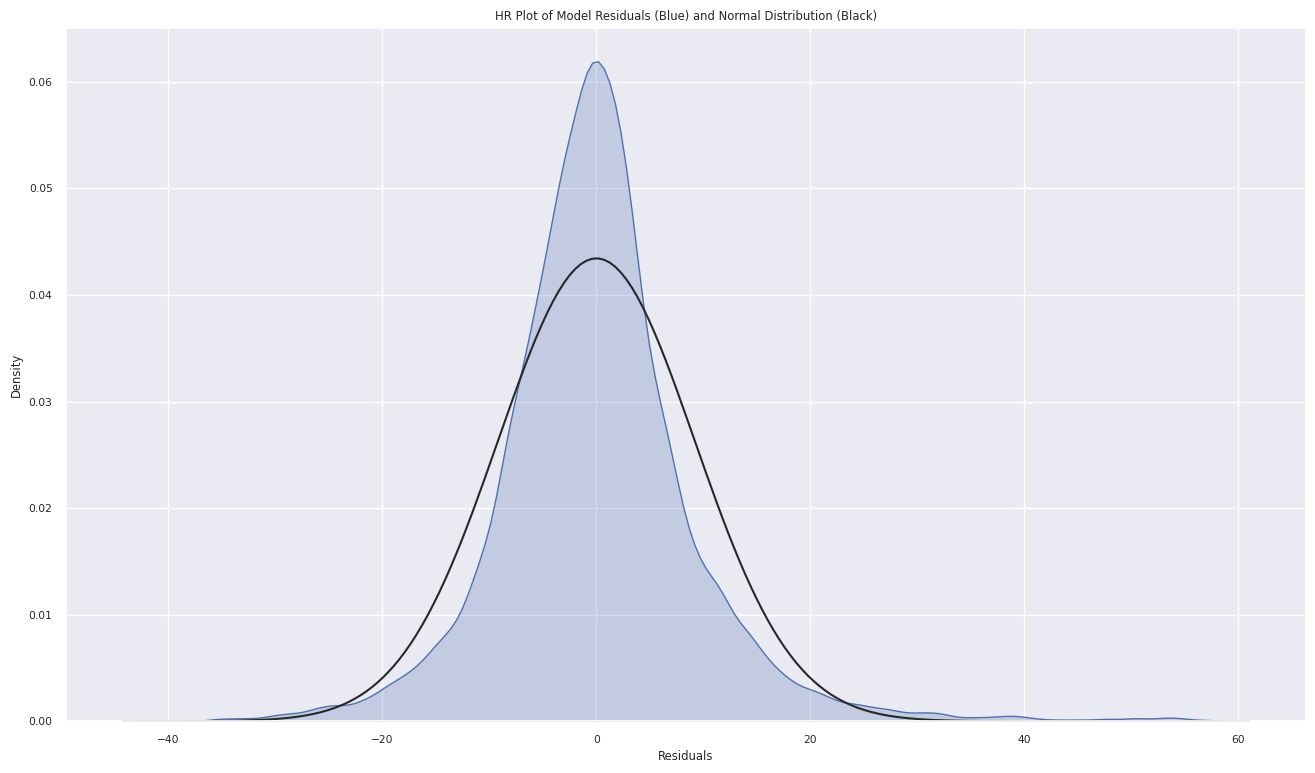

In [ ]:
import scipy.stats as stats
fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("HR Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

#### - Interpretation:
Although there is a slight departure from normality in the data, it does not appear to be a significant concern. Furthermore, there is an outliers that are clearly visible in the plots. That shows that the data might need to be improved a little bit.




<ipython-input-58-c4926a407b5e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mdf1.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


Text(0.5, 0, 'Residuals')

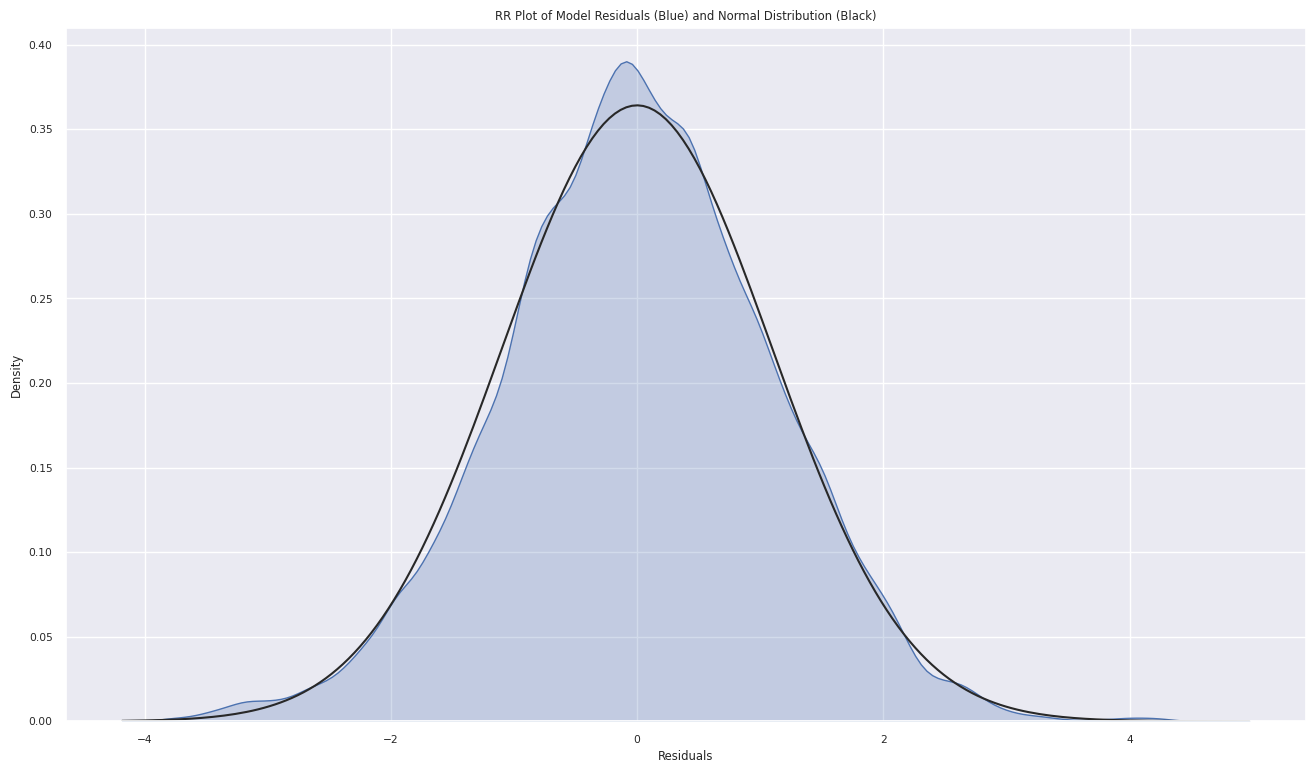

In [ ]:

fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(mdf1.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("RR Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

#### - Interpretation:
* The residual of `respr` shows a bell shape distribution so this model comply with the normality assumption of residuals. We can also mention that the results of the article compare with are model are similar and we can Validate their results.

Text(0.5, 1.0, 'Q-Q Plot')

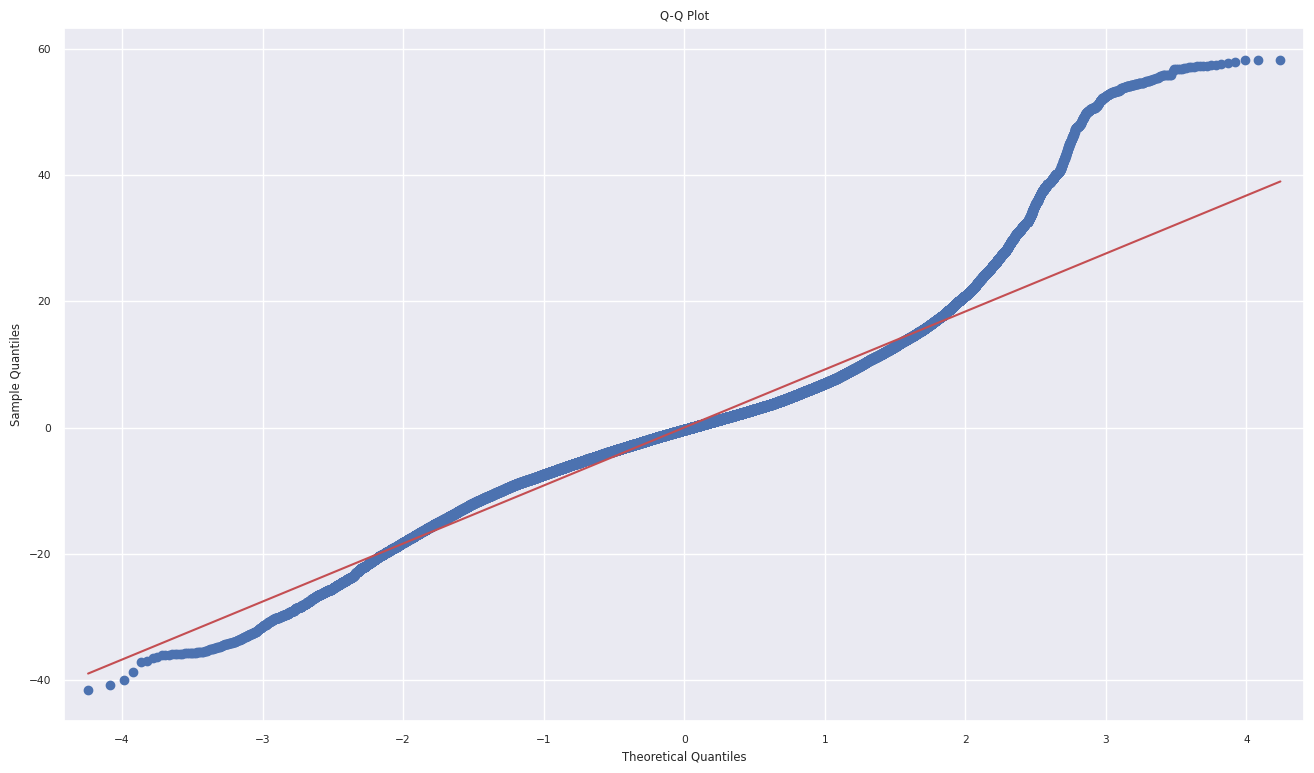

In [ ]:
#Q_Q PLot
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(mdf.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

#### - Interpretation:
Q-Q plot also show a slight deviation from the theorical normal distribution of the residuals. We have to consider that are values are differents from the results of the article and thats why they have significant statitiscal results in their data.

Text(0.5, 1.0, 'Q-Q Plot')

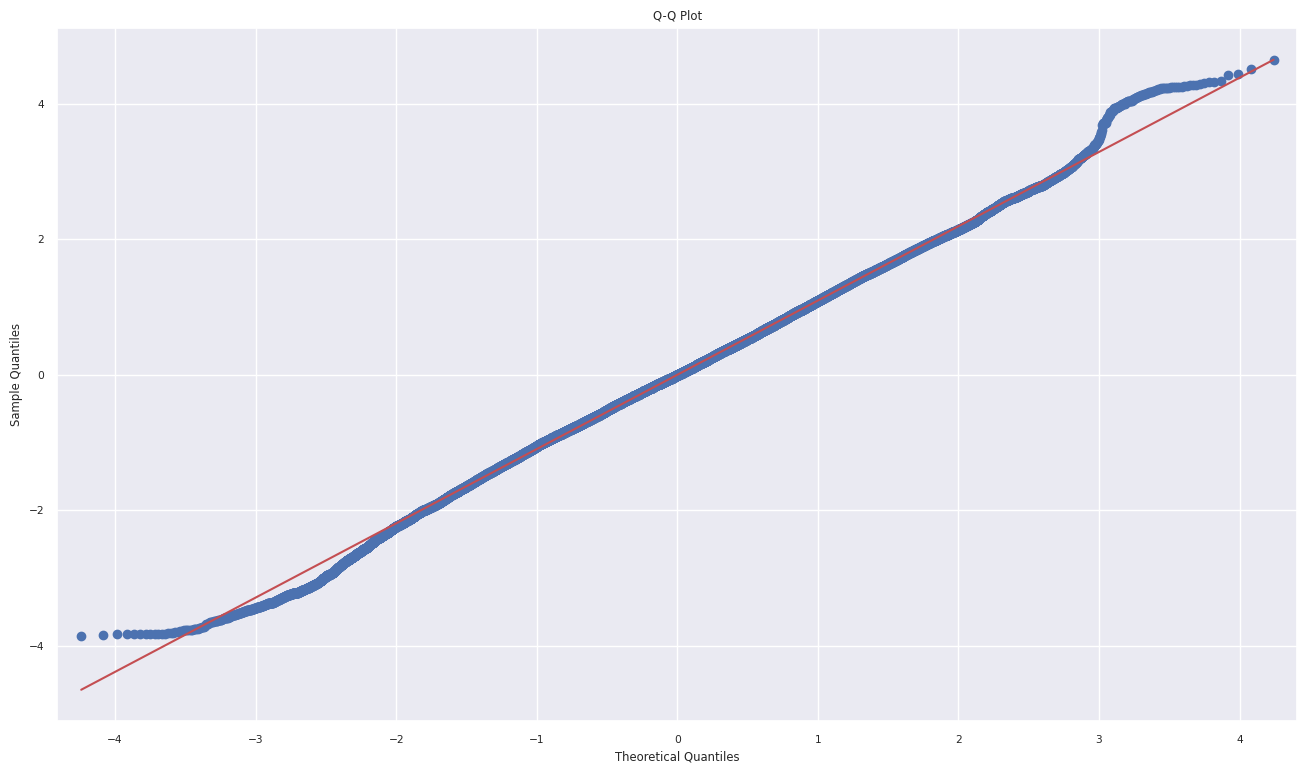

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(mdf1.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

#### - Interpretation:
Q-Q plot show that the model follows the theorical normal distribution of the residuals. In the case of predicting the `respr` we had almost similar result compared to the article and that help us to validate their results.

##### **- Homoscedasticity of variances, assumption of residual:**

In this part, we try to validate our results and compare the results of the article.

Text(0.5, 0, 'Fitted Values')

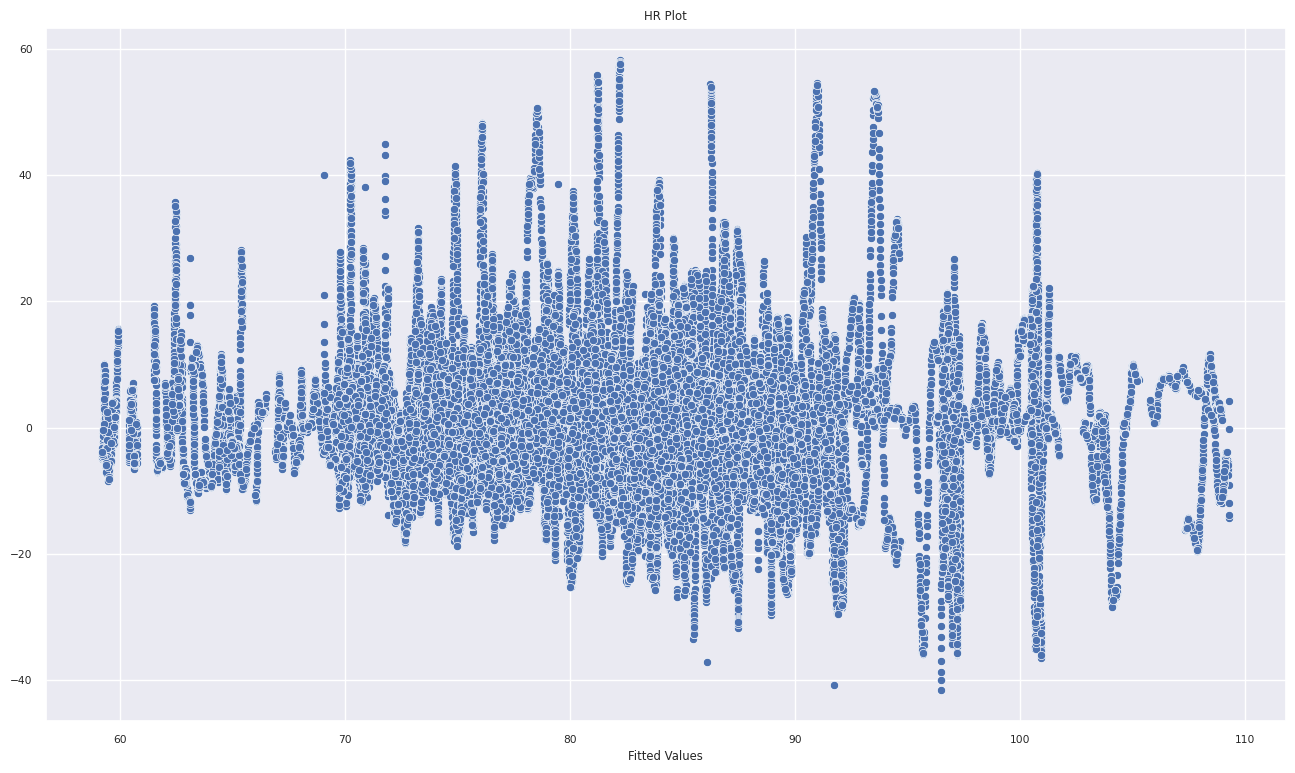

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = mdf.resid, x = mdf.fittedvalues)

ax.set_title("HR Plot")
ax.set_xlabel("Fitted Values")

Text(0.5, 0, 'Fitted Values')

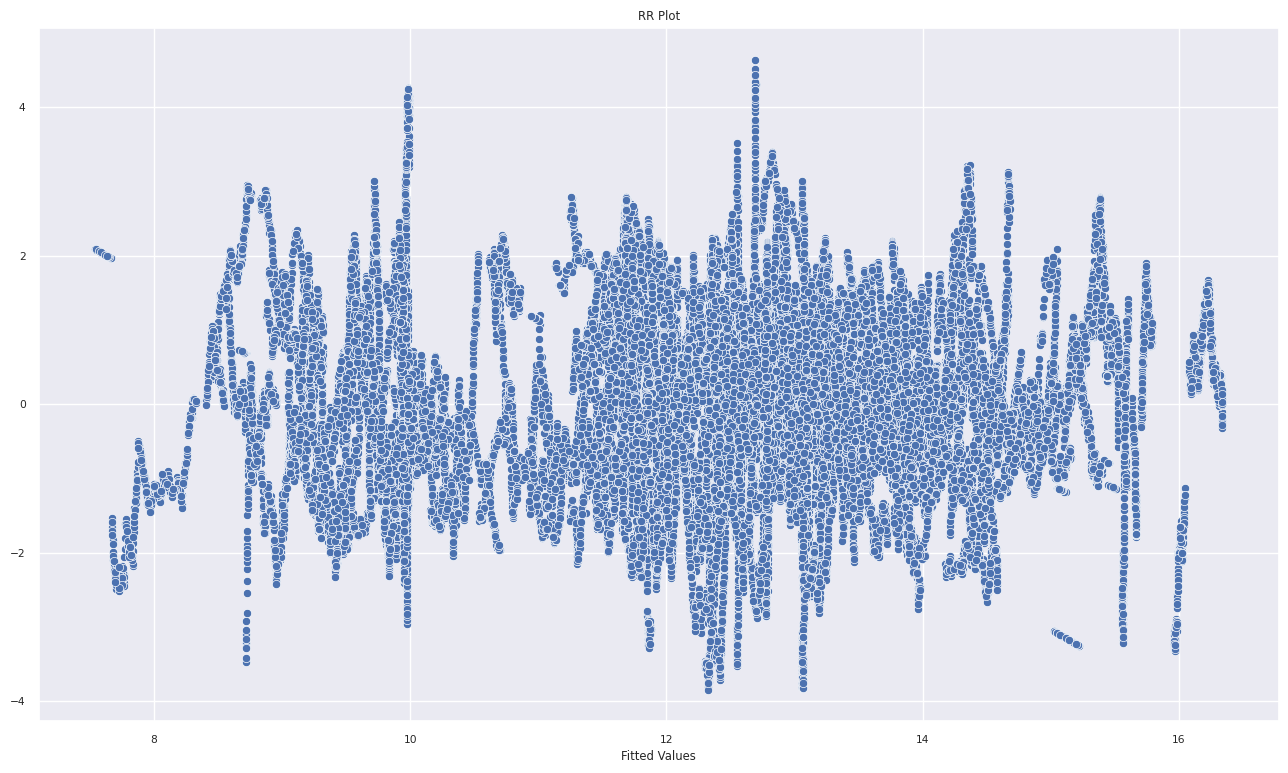

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = mdf1.resid, x = mdf1.fittedvalues)

ax.set_title("RR Plot")
ax.set_xlabel("Fitted Values")

#### - Interpretation:

* According to the visual tests,  boths plots that not shows any specific pattern, there seems to be little cause for concern regarding the violation of the assumption of homoscedasticity (equal variance).



# 5. Conclusions

* The missing value of the data set represents less than 5% of the data so we decided to drop them. The article does not mention the missing values but shows the number of observations that they used is exactly the same as what we obtained after we dropped the missing values in the dataset.

* We decided not to modify the outliers due to the nature of the quasi-experiment and the data itself.

* The sample size to train the model was 80% of the data with a random sample of it.

* The term `Group` was set as a Fixed effect as mentioned in the article. The p_value for this variable showed statistically significant importance in both models with p_value < 0.05.

* The term `Time` was considered as a Random effect for the individual since we have repeated measures in the same subjects then the data points of `Time` for every `Particpant` depend on each other. In this case, we allowed to have different intercepts and slopes for every Participant but those are random. This variable `Time` was not statistically significant important for both models (HR and RR model) with p_value > 0.05.

* For RR model, there is not meaninful average difference between the RR average values for Group 0 (stress) and Group 1 (normal).

* The coefficients of `RR` Model and  `HR` Model gave us similar results compared to the article, which means qe could simulate the model almost equally. Just taking into consideration the statistical significance of the term (p_values) we can say are results are similar as well.

* The variable participant was set as part of the cluster for the mixed linear model that we have.

